# Checking EEG code

Some reference code (to be checked):

- https://github.com/AliAmini93/ADHDeepNet/tree/main

**ADHD data**: https://ieee-dataport.org/open-access/eeg-data-adhd-control-children

## Data loading

Dataframe `adhd_df` will contain EEG data for all patients diagnosed with ADHD (for the 19 electrodes), plus one column with the ID of the patient. 

Dataframe `control_df` will be the equivalent for the control patients. 

In [ ]:
pip install scipy

In [ ]:
pip install numpy pandas scipy matplotlib seaborn

In [ ]:
!pip install jupyterlab ipywidgets  
!pip install tqdm                   
!pip install einops                
!pip install h5py                   

In [ ]:
!pip install mne mne-bids pybv   
!pip install pyedflib            
!pip install braindecode         

In [ ]:
pip install numpy==1.24.4


In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)


In [453]:
# Data loading
from pathlib import Path
import scipy.io as sio

import numpy as np
import pandas as pd

data_dir = Path.home() / Path(r"C:\Users\User\EEG-Conformer-main")

In [454]:
# Channel labels and electrode positions
channel_labels = {
    0: "Fp1",
    1: "Fp2",
    2: "F3",
    3: "F4",
    4: "C3",
    5: "C4",
    6: "P3",
    7: "P4",
    8: "O1",
    9: "O2",
    10: "F7",
    11: "F8",
    12: "T7",
    13: "T8",
    14: "P7",
    15: "P8",
    16: "Fz",
    17: "Cz",
    18: "Pz",
}

electrode_positions = {
    "Fp1": (-18, 0.511, 0.95, 0.309, -0.0349, 18, -2, 1),
    "Fp2": (18, 0.511, 0.95, -0.309, -0.0349, -18, -2, 1),
    "F7": (-54, 0.511, 0.587, 0.809, -0.0349, 54, -2, 1),
    "F3": (-39, 0.333, 0.673, 0.545, 0.5, 39, 30, 1),
    "Fz": (0, 0.256, 0.719, 0, 0.695, 0, 44, 1),
    "F4": (39, 0.333, 0.673, -0.545, 0.5, -39, 30, 1),
    "F8": (54, 0.511, 0.587, -0.809, -0.0349, -54, -2, 1),
    "T7": (-90, 0.511, 6.12e-17, 0.999, -0.0349, 90, -2, 1),
    "C3": (-90, 0.256, 4.4e-17, 0.719, 0.695, 90, 44, 1),
    "Cz": (90, 0, 3.75e-33, -6.12e-17, 1, -90, 90, 1),
    "C4": (90, 0.256, 4.4e-17, -0.719, 0.695, -90, 44, 1),
    "T8": (90, 0.511, 6.12e-17, -0.999, -0.0349, -90, -2, 1),
    "P7": (-126, 0.511, -0.587, 0.809, -0.0349, 126, -2, 1),
    "P3": (-141, 0.333, -0.673, 0.545, 0.5, 141, 30, 1),
    "Pz": (180, 0.256, -0.719, -8.81e-17, 0.695, -180, 44, 1),
    "P4": (141, 0.333, -0.673, -0.545, 0.5, -141, 30, 1),
    "P8": (126, 0.511, -0.587, -0.809, -0.0349, -126, -2, 1),
    "O1": (-162, 0.511, -0.95, 0.309, -0.0349, 162, -2, 1),
    "O2": (162, 0.511, -0.95, -0.309, -0.0349, -162, -2, 1),
}

# Sampling Frequency Hz
Sampling_Frequency = 128

# Set the chunk size
chunk_size = 512

In [455]:
def split_into_chunks(df, chunk_size, initial_chunk_number=0):
    # Calculate the number of full chunks
    n_chunks = len(df) // chunk_size
    chunks = []

    # Split into chunks and keep track of the chunk number
    for i in range(n_chunks):
        chunk = df.iloc[i * chunk_size : (i + 1) * chunk_size].copy()  # Get the chunk
        chunk["chunk_number"] = (
            initial_chunk_number + i
        )  # Add the chunk number as a new column
        chunks.append(chunk)

    # Concatenate the chunks back together
    return pd.concat(chunks, ignore_index=True), n_chunks

In [456]:
def load_data(data_dirs):
    data_list = []
    chunked_data_list = []

    chunk_index = 0
    for directory in data_dirs:
        # print(f"Loading data from {directory}")

        for filepath in directory.glob("*.mat"):
            mat = sio.loadmat(filepath)
            key = list(mat.keys())[-1]  # Get the last key (the id of the patient)
            eeg_data = mat[key]

            # Convert the EEG data to a DataFrame
            # Assuming the EEG data is a 2D array (time x channels)
            df = pd.DataFrame(eeg_data)
            df = df.rename(columns=channel_labels)
            # Add a column to identify the source
            df["subject_id"] = key

            # print(f"Loaded data for patient {key}; chunks start at {chunk_index}")
            chucked_df, chunks = split_into_chunks(df, chunk_size, chunk_index)
            chunk_index += chunks

            # Append the DataFrame to the list
            data_list.append(df)
            chunked_data_list.append(chucked_df)

        # Concatenate all DataFrames in the list into a single DataFrame
        full_eeg_df = pd.concat(data_list, ignore_index=True)
        chunked_eeg_df = pd.concat(chunked_data_list, ignore_index=True)

    return full_eeg_df, chunked_eeg_df

In [457]:
adhd_dir1 = data_dir / Path("ADHD_part1")
adhd_dir2 = data_dir / Path("ADHD_part2")
adhd_df, adhd_chunks_df = load_data([adhd_dir1, adhd_dir2])

control_dir1 = data_dir / Path("Control_part1")
control_dir2 = data_dir / Path("Control_part2")
control_df, control_chunks_df = load_data([control_dir1, control_dir2])

### Some sanity checks on the data

Number of ADHD subjects: 61
Number of Control subjects: 60
Number of subjects in both groups: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1207069 entries, 0 to 1207068
Data columns (total 20 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   Fp1         1207069 non-null  float64
 1   Fp2         1207069 non-null  float64
 2   F3          1207069 non-null  float64
 3   F4          1207069 non-null  float64
 4   C3          1207069 non-null  float64
 5   C4          1207069 non-null  float64
 6   P3          1207069 non-null  float64
 7   P4          1207069 non-null  float64
 8   O1          1207069 non-null  float64
 9   O2          1207069 non-null  float64
 10  F7          1207069 non-null  float64
 11  F8          1207069 non-null  float64
 12  T7          1207069 non-null  float64
 13  T8          1207069 non-null  float64
 14  P7          1207069 non-null  float64
 15  P8          1207069 non-null  float64
 16  Fz          

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >], dtype=object)

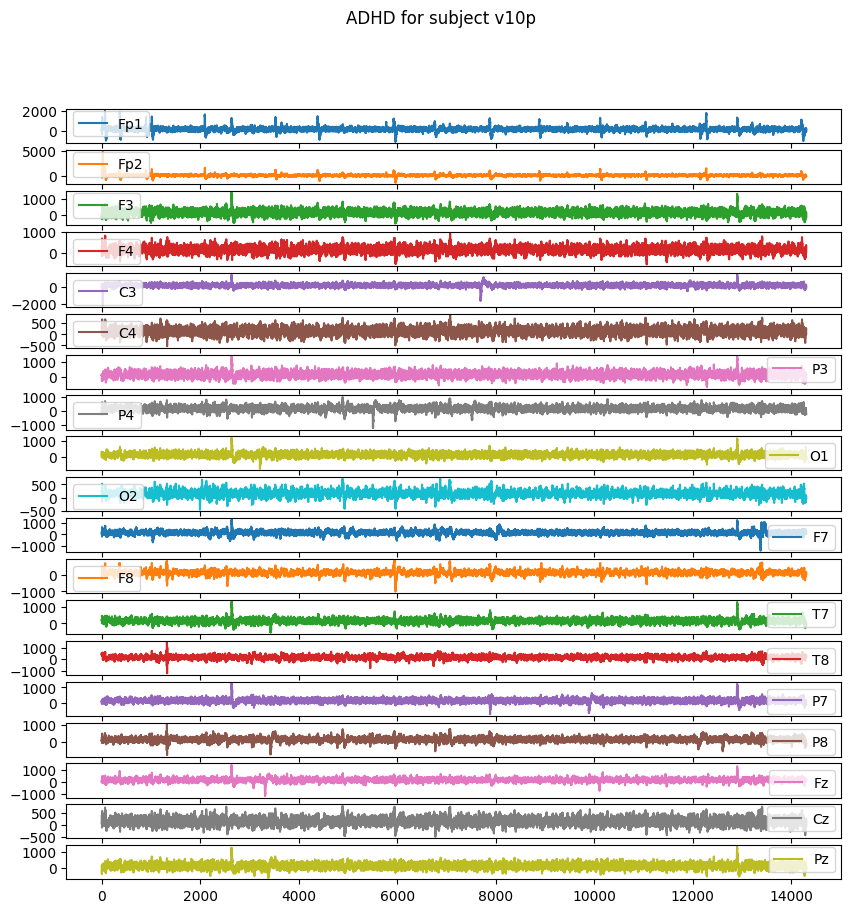

In [458]:
adhd_subjects = adhd_df["subject_id"].unique()
control_subjects = control_df["subject_id"].unique()
intersection = [item for item in adhd_subjects if item in control_subjects]


num_patients = len(adhd_subjects) + len(control_subjects)
num_data_points = adhd_df.shape[0] + control_df.shape[0]
num_chunks = 0
num_chunks2 = 0

print(f"Number of ADHD subjects: {len(adhd_subjects)}")
print(f"Number of Control subjects: {len(control_subjects)}")
print(f"Number of subjects in both groups: {len(intersection)}")

print(adhd_df.info())
print(control_df.info())

print(adhd_df.describe())
print(control_df.describe())

chunck_size = 512

num_chunks = 0
for patient in adhd_subjects:
    data_points = adhd_df[adhd_df["subject_id"] == patient].shape[0]
    num_chunks += data_points // chunck_size

print(f"ADHD - total number of data points: {adhd_df.shape[0]:,}")
print(f"ADHD - total number of chunks of size {chunck_size}: {num_chunks}")

num_chunks = 0
for patient in control_subjects:
    data_points = control_df[control_df["subject_id"] == patient].shape[0]
    num_chunks += data_points // chunck_size

print(f"Control - total number of data points: {control_df.shape[0]:,}")
print(f"Control - total number of chunks of size {chunck_size}: {num_chunks}")

adhd_df[adhd_df['subject_id']==adhd_subjects[0]].drop(columns=['subject_id']).plot(subplots=True, figsize=(10, 10), title='ADHD for subject ' + adhd_subjects[0])

In [459]:
print("*****\nADHD subjects\n*****")
for subject in adhd_subjects:
    print(
        f"Subject {subject} has {adhd_df[adhd_df['subject_id']==subject].shape[0]} data points"
    )

print("*****\nControl subjects\n*****")
for subject in control_subjects:
    print(
        f"Subject {subject} has {control_df[control_df['subject_id']==subject].shape[0]} data points"
    )

*****
ADHD subjects
*****
Subject v10p has 14304 data points
Subject v12p has 17604 data points
Subject v14p has 17562 data points
Subject v15p has 43252 data points
Subject v173 has 24241 data points
Subject v18p has 25003 data points
Subject v19p has 23063 data points
Subject v1p has 12258 data points
Subject v20p has 35328 data points
Subject v21p has 16574 data points
Subject v22p has 12100 data points
Subject v24p has 16385 data points
Subject v25p has 9894 data points
Subject v27p has 28880 data points
Subject v28p has 27612 data points
Subject v29p has 24193 data points
Subject v30p has 21663 data points
Subject v31p has 11679 data points
Subject v32p has 18049 data points
Subject v33p has 29217 data points
Subject v34p has 19555 data points
Subject v35p has 15305 data points
Subject v36p has 17401 data points
Subject v37p has 9286 data points
Subject v38p has 24695 data points
Subject v39p has 18177 data points
Subject v3p has 33570 data points
Subject v40p has 20097 data point

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >], dtype=object)

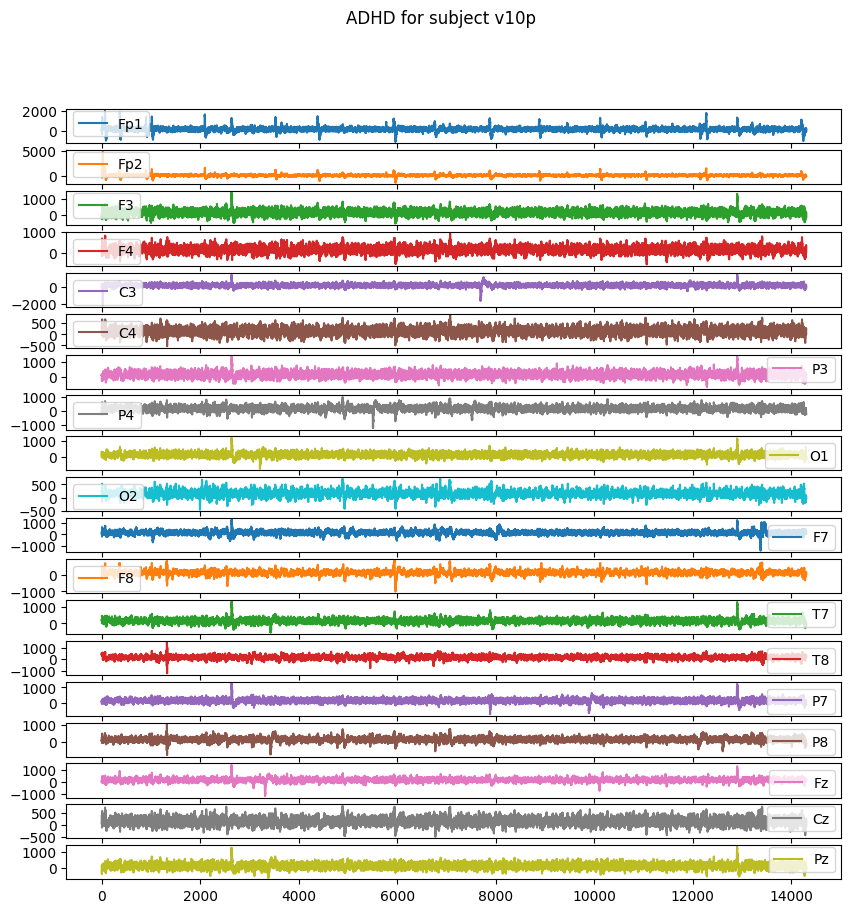

In [460]:
subject = adhd_subjects[0]
df = adhd_df[adhd_df['subject_id']==subject].drop(columns=['subject_id'])
df.plot(subplots=True, figsize=(10, 10), title='ADHD for subject ' + subject)

### Organise data into chunks

In [461]:
conda install pytables

Channels:
 - defaults
 - conda-forge
Platform: win-64
Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [462]:
# Let's put all the data together (we will use the "chunked" data)
adhd_chunks_df["label"] = "ADHD"
control_chunks_df["label"] = "Control"

# we need to "renumber" the chunks for the control data so that they are continuous with the ADHD data
control_chunks_df["chunk_number"] += adhd_chunks_df["chunk_number"].max() + 1

all_data_df = pd.concat([adhd_chunks_df, control_chunks_df], ignore_index=True)

print(all_data_df["chunk_number"].nunique())


all_data_df.to_hdf("adhd_data.h5", key="all_data_df", mode="w")

4173


In [463]:
chunks_df = (
    all_data_df[["chunk_number", "subject_id", "label"]]
    .drop_duplicates()
    .reset_index(drop=True)
)
chunks_df = pd.get_dummies(chunks_df, columns=["label"])
print(chunks_df.shape)

(4173, 4)


In [464]:
!pip install einops

In [465]:
# Let's reshape the data into a 3D array (chunks x channels x samples)
import einops

raw_data = all_data_df.drop(columns=["subject_id", "label"])
# raw_data.info()

# 1. Extract the data (excluding the 'chunk_number' column)
raw_data = raw_data.iloc[:, :-1].values  # shape will be (#tot_samples, 19)

# 2. Reshape the data into a 3D array
num_chunks = chunks_df.shape[0]
eeg_data = einops.rearrange(
    raw_data,
    "(chunks points) electrodes -> chunks electrodes points",
    chunks=num_chunks,
    points=chunk_size,
)

print(eeg_data.shape)

(4173, 19, 512)


## Model

### Prepare the data for model training

In [466]:
X = eeg_data
# expand the dimensions to make it compatible with the Conv1D layer in Keras
# the new shape will be (#tot_samples, 1, 19, 512)
X = np.expand_dims(X, axis=1)

y = chunks_df[["label_ADHD", "label_Control"]].values

# Set the random seed for reproducibility
np.random.seed(42)

# 1. Generate a random permutation of the indices
indices = np.random.permutation(len(X))

# 2. Use the first 80% of the indices for the training set
# train_size = int(0.8 * len(X))
train_size = 3695

# 3. Split the indices into train and test sets
train_indices = indices[:train_size]
test_indices = indices[train_size:]

X_train = X[train_indices]
X_test = X[test_indices]

y_train = y[train_indices]
y_test = y[test_indices]

chunks_train = chunks_df.iloc[train_indices].values
chunks_test = chunks_df.iloc[test_indices].values

print(X_train.shape, y_train.shape, chunks_train.shape)
print(X_test.shape, y_test.shape, chunks_test.shape)

(3695, 1, 19, 512) (3695, 2) (3695, 4)
(478, 1, 19, 512) (478, 2) (478, 4)


In [467]:
# Transform all labels to proper one-hot encoding (integers instead of booleans) - not needed
# y_train = y_train.astype(int)
# y_test = y_test.astype(int)

Group_train = chunks_train[:, [0, 1]]
Group_test = chunks_test[:, [0, 1]]

In [468]:
label_distr_counts_train = np.sum(y_train, axis=0)
label_distr_counts_test = np.sum(y_test, axis=0)

print(f"Training set: {label_distr_counts_train[0]} ADHD /  {label_distr_counts_train[1]} Control")
print(f"Test set: {label_distr_counts_test[0]} ADHD /  {label_distr_counts_test[1]} Control")

Training set: 2072 ADHD /  1623 Control
Test set: 258 ADHD /  220 Control


### Build the model

In [469]:
import sys
print(sys.version)

3.10.18 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:08:55) [MSC v.1929 64 bit (AMD64)]


In [470]:
import tensorflow as tf
print(tf.__version__)  
tf.config.list_physical_devices()  

2.10.0


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [471]:
from tensorflow.keras import backend as K

K.set_image_data_format("channels_first")

In [472]:
import numpy as np
import pandas as pd



In [473]:
pip install scipy scikit-learn --upgrade

Note: you may need to restart the kernel to use updated packages.


In [474]:
import sklearn
print("sklearn version:", sklearn.__version__)

sklearn version: 1.7.1


In [475]:
# from pyriemann.utils.viz import plot_confusion_matrix
from sklearn.metrics import fbeta_score

def subject_classification1(y_true, y_pred, group, calculate_type="max_vote"):
    """
    y_pred should be the output of 'model.predict' using 2 nodes in the dense layer and softmax activation.
    y_true should be in categorical mode.
    """

    # Categorical to normal labeling
    # NB: 0 will indicate ADHD and 1 will indicate Control (TO BE CHECKED)
    y_true = y_true.argmax(axis=-1)    
    probability = np.array(y_pred)
    # Turn predictions to one hot
    max_indices = np.argmax(y_pred, axis=1)
    prediction_one_hot = np.zeros((y_pred.shape[0], y_pred.shape[1]))
    prediction_one_hot[np.arange(y_pred.shape[0]), max_indices] = 1
    
    max_vote = []
    subject_target = []

    # Combine prediction probabilities and subject labels
    probability = np.concatenate((probability, group), axis=1)
    # Convert combined array to DataFrame
    probability_df = pd.DataFrame(probability, columns=['ADHD', 'Control', 'Subject'])
    # Make sure the prediction columns are float
    probability_df[['ADHD', 'Control']] = probability_df[['ADHD', 'Control']].astype(float)
    # Compute mean of predictions per unique subject
    mean_predictions_per_subject = probability_df.groupby('Subject').mean()
    # Make sure the the groups are sorted by the grouping key (the subject id) after grouping
    mean_predictions_per_subject = mean_predictions_per_subject.sort_index()
    # Revert the DataFrame to a numpy array
    mean_predictions_per_subject = mean_predictions_per_subject.to_numpy()
    mean_ = mean_predictions_per_subject.argmax(axis=-1)

    # Combine prediction classes and subject labels
    prediction = np.concatenate((prediction_one_hot, group), axis=1)
    # Convert combined array to DataFrame
    prediction_df = pd.DataFrame(prediction, columns=['ADHD', 'Control', 'Subject'])
    # Make sure the prediction columns are int
    prediction_df[['ADHD', 'Control']] = prediction_df[['ADHD', 'Control']].astype(int)
    # Compute total number a class was predicted per unique subject
    sum_predictions_per_subject = prediction_df.groupby('Subject').sum()
    # # Make sure the the groups are sorted by the grouping key (the subject id) after grouping
    sum_predictions_per_subject = sum_predictions_per_subject.sort_index()
    # Revert the DataFrame to a numpy array
    sum_predictions_per_subject = sum_predictions_per_subject.to_numpy()
    # sum_predictions_per_subject
    max_vote = np.argmax(sum_predictions_per_subject, axis=1)
    subject_target = np.array(y_true)

    # # j = 0
    # # unique, counts = np.unique(group, return_counts=True)
    # # mean_ = np.zeros([len(unique), 2], dtype="float32")
    # # for i in range(len(unique)):
    # #     for k in range(2):
    # #         mean_[i][k] = np.mean(probability[j : j + counts[i] - 1, k])
    # #     c = np.bincount(prediction[j : j + counts[i] - 1])
    # #     max_vote.append(np.argmax(c))
    # #     subject_traget.append(y_true[j])
    # #     j = j + counts[i]
    # # mean_ = mean_.argmax(axis=-1)
    # # max_vote = np.array(max_vote)
    # # subject_traget = np.array(subject_traget)

    f2_max_vote = fbeta_score(subject_target, max_vote, beta=0.5, average="binary")
    f2_mean = fbeta_score(subject_target, mean_, beta=0.5, average="binary")
    acc_max_vote = np.mean(max_vote == subject_target)
    acc_mean = np.mean(mean_ == subject_target)
    if calculate_type == 'max_vote':
        return acc_max_vote, f2_max_vote
    elif calculate_type == 'mean':
        return acc_mean, f2_mean
    else:
        raise ValueError('You have NOT entered an accurate type!')

In [476]:
def augment_time_series_data(data, label, sigma, magnification_factor):
    augmented_data = []
    augmented_label = []

    n, _, electrodes, time_steps = data.shape
    if sigma[0] == 0 and magnification_factor[0] == 0:
        return data, label
    else:
        # loop through each sample
        for i in range(n):
            for s in sigma:
                for m in magnification_factor:
                    # generate noise with the given sigma
                    noise = np.random.normal(0, s, (electrodes, time_steps))

                    # augment the data with the noise and magnification factor
                    augmented_sample = data[i, :, :, :] + noise * m
                    augmented_data.append(augmented_sample)

                    # augment the label with the same label
                    augmented_label.append(label[i])
        # change list to numpy array
        augmented_data, augmented_label = np.array(augmented_data), np.array(
            augmented_label
        )

        return np.concatenate((data, augmented_data)), np.concatenate(
            (label, augmented_label)
        )

In [477]:
import itertools
# from itertools import combinations

def generate_combinations(magnification_factor, sigma):
    result = [{"magnification_factor": [0], "sigma": [0]}]
    for i in range(1, 4):
        for m_comb in itertools.combinations(magnification_factor, i):
            for sigma_comb in itertools.combinations(sigma, i):
                result.append(
                    {"magnification_factor": list(m_comb), "sigma": list(sigma_comb)}
                )
    return result

In [478]:
def sample_classification(y_true, y_pred):
    """
    y_pred should be the output of 'model.predict' using 2 nodes in the dense layer and softmax activation.
    y_true should be in categorical mode.
    """
    preds = y_pred.argmax(axis=-1)
    acc = np.mean(preds == y_true.argmax(axis=-1))
    f2 = fbeta_score(y_true.argmax(axis=-1), preds, beta=0.5, average="binary")
    return acc, f2

In [479]:
def ClassWeightSoftmax(y):
    class_weights = compute_class_weight(
        class_weight="balanced", classes=np.unique(Y_train), y=Y_train
    )
    class_weights = dict(zip(np.unique(Y_train), class_weights))
    class_weights[0] = int(10 * round(class_weights[0], 1))
    class_weights[1] = int(10 * round(class_weights[1], 1))
    class_weight = [{0: 1, 1: class_weights[0]}, {0: 1, 1: class_weights[1]}]
    print("The Class Weight is:", class_weight)
    return class_weight

In [480]:
pip install tensorflow-addons


Note: you may need to restart the kernel to use updated packages.


In [481]:
import tensorflow_addons as tfa

adamw = tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=1e-4)


In [482]:
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.optimizers.experimental import AdamW


In [483]:
adamw = AdamW(learning_rate=0.001, weight_decay=1e-4)


In [484]:
pip install scikit-optimize


Note: you may need to restart the kernel to use updated packages.


In [485]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer


In [491]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import utils as np_utils
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout, multiply, LSTM
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler

from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.optimizers.experimental import AdamW

from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import GlobalAveragePooling2D
from keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score
import math
import gc
from numpy import mean
from numpy import std
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import cross_val_score
from skopt.utils import use_named_args
from skopt import gp_minimize
import tensorflow as tf
import numpy as np
from tensorflow.keras import backend as K
K.set_image_data_format('channels_last')


def TactileNet(
    nb_classes=2,
    Chans=19,
    Samples=512,
    kernLength=16,
    F2=64,
    F1=64,
    D=4,
    dropoutRate=0.5,
    dropoutType="Dropout",
    norm_rate=0.25,
    Dense_nodes=16,
    optimizer_type="Adam",
    lr=0.001,
    **kwargs
):
    if dropoutType == "SpatialDropout2D":
        dropoutType = SpatialDropout2D
    elif dropoutType == "Dropout":
        dropoutType = Dropout
    else:
        raise ValueError("Invalid dropout type.")

    # ✅ NHWC input: (19, 512, 1)
    input1 = Input(shape=(Chans, Samples, 1))

    block1 = Conv2D(
        F1,
        (1, kernLength),
        padding="same",
        use_bias=False,
    )(input1)
    block1 = BatchNormalization(axis=-1, trainable=True)(block1)

    block1 = DepthwiseConv2D(
        (Chans, 1),
        use_bias=False,
        depth_multiplier=D,
        depthwise_constraint=max_norm(norm_rate),
        padding="same"
    )(block1)
    block1 = BatchNormalization(axis=-1, trainable=True)(block1)
    block1 = Activation("elu")(block1)
    block1 = AveragePooling2D((1, 2))(block1)
    block1 = dropoutType(dropoutRate)(block1)

    # ───── Towers ───── #
    sub_block1 = Conv2D(64, (1, 1), padding="same", use_bias=False)(block1)
    sub_block1 = SeparableConv2D(128, (1, 128), padding="same", use_bias=False)(sub_block1)
    sub_block1 = AveragePooling2D((1, 2), padding="same")(sub_block1)

    sub_block2 = Conv2D(16, (1, 1), padding="same", use_bias=False)(block1)
    sub_block2 = SeparableConv2D(32, (1, 256), padding="same", use_bias=False)(sub_block2)
    sub_block2 = AveragePooling2D((1, 2), padding="same")(sub_block2)

    sub_block3 = Conv2D(64, (1, 1), padding="same", strides=(1, 2), use_bias=False)(block1)

    sub_block4 = AveragePooling2D((1, 2), padding="same")(block1)
    sub_block4 = Conv2D(32, (1, 1), padding="same", use_bias=False)(sub_block4)

    # Concat along channels
    concat = concatenate([sub_block1, sub_block2, sub_block3, sub_block4], axis=-1)

    block2 = BatchNormalization(axis=-1, trainable=True)(concat)
    block2 = Activation("elu")(block2)

    # Squeeze-and-Excitation
    squeeze1 = GlobalAveragePooling2D()(block2)
    excitation1 = Dense(Dense_nodes, activation="relu")(squeeze1)
    excitation1 = Dense(K.int_shape(block2)[-1], activation="sigmoid")(excitation1)
    excitation1 = multiply([block2, tf.reshape(excitation1, [-1, 1, 1, K.int_shape(block2)[-1]])])

    block2 = SeparableConv2D(256, (1, 64), padding="same", use_bias=False)(excitation1)
    block2 = BatchNormalization(axis=-1, trainable=True)(block2)
    block2 = Activation("elu")(block2)

    # 2nd Squeeze-and-Excitation
    squeeze2 = GlobalAveragePooling2D()(block2)
    excitation2 = Dense(Dense_nodes, activation="relu")(squeeze2)
    excitation2 = Dense(K.int_shape(block2)[-1], activation="sigmoid")(excitation2)
    excitation2 = multiply([block2, tf.reshape(excitation2, [-1, 1, 1, K.int_shape(block2)[-1]])])

    block2 = dropoutType(dropoutRate)(excitation2)
    GB = GlobalAveragePooling2D()(block2)

    denselayer = Dense(nb_classes, name="denselayer", kernel_constraint=max_norm(norm_rate))(GB)
    softmax = Activation("softmax", name="softmax")(denselayer)

    # Optimizer
    if optimizer_type == "Adam":
        optimizer = Adam(learning_rate=lr)
    elif optimizer_type == "Adamax":
        optimizer = Adamax(learning_rate=lr)
    elif optimizer_type == "AdamW":
        optimizer = AdamW(learning_rate=lr)
    else:
        raise ValueError("Unsupported optimizer")

    model = Model(inputs=input1, outputs=softmax)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model


### Training

In [506]:
model = TactileNet()
print(model.summary())

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_28 (InputLayer)          [(None, 19, 512, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_88 (Conv2D)             (None, 19, 512, 64)  1024        ['input_28[0][0]']               
                                                                                                  
 batch_normalization_80 (BatchN  (None, 19, 512, 64)  256        ['conv2d_88[0][0]']              
 ormalization)                                                                                    
                                                                                           

In [507]:
print("Model input shape:", DB_saved_model.input_shape) 
# Should confirm (None, 1, 19, 512)

Model input shape: (None, 19, 512, 1)


In [ ]:
#model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=1)

In [508]:
# define the space of hyperparameters to search
search_space = list()
search_space.append(Categorical([8, 16, 32, 64], name="F1"))
search_space.append(Categorical([16, 32, 64, 128, 256], name="F2"))
search_space.append(Categorical([2, 4, 8], name="D"))
search_space.append(Categorical([32, 64, 128, 256, 512], name="kernLength"))
search_space.append(Categorical([8, 16, 32], name="Dense_nodes"))
search_space.append(Categorical([0.5, 1.0, 5.0, 10.0], name="norm_rate"))
search_space.append(Categorical([0.0001, 0.0005, 0.001, 0.005, 0.01], name="lr"))
search_space.append(Categorical(["Adam", "Adamax", "AdamW"], name="optimizer"))
search_space.append(Categorical([0.3, 0.4, 0.5], name="dropoutRate"))
search_space.append(Categorical([32, 64, 128], name="batch_size"))


# define the function used to evaluate a given configuration
@use_named_args(search_space)
def evaluate_model(**params):
    sample_acc = []
    sample_f2 = []
    subject_acc = []
    subject_f2 = []
    sample_loss = []
    ### Defining SKGF ###
    #######################
    # Callbacks #
    # modelpath = "./Bayesian Saved Model/model_{epoch:02d}_{val_loss:.2f}.keras"
    model_path = "./Bayesian Saved Model/model.keras"
    checkpoint = ModelCheckpoint(
        model_path, monitor="val_accuracy", verbose=1, save_best_only=True, mode="max"
    )
    es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=15)
    keras_reduce_lr = ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=10, min_lr=0.00005, verbose=2
    )
    callbacks = [checkpoint, es, keras_reduce_lr]
    model = TactileNet(**params)
    # Fitting ...
    fit = model.fit(
        X_train,
        y_train,
        verbose=2,
        shuffle=True,
        # epochs=100,
        epochs=2, # changed to keep training short
        batch_size=params["batch_size"],
        validation_data=(X_test, y_test),
        callbacks=callbacks,
    )

    del model, fit

    ### Loading The Best Saved Model ###
    saved_model = load_model(model_path)
    
    # Predict The model
    test_predict = saved_model.predict(X_test)
    test_loss, test_acc = saved_model.evaluate(X_test, y_test)
    ######################################################################################################
    print("test_loss", test_loss)
    print("test_acc", test_acc)
    ######################################################################################################

    # Select the true labels for the (unique) subjects
    _, indices = np.unique(Group_test[:, 1], return_index=True)
    subject_true_pred = y_test[indices]

    Group_test_labels = Group_test[:, 1].reshape(-1, 1)

    sub_acc, sub_f2 = subject_classification1(
        subject_true_pred, test_predict, Group_test_labels, calculate_type="max_vote"
    )
    sam_acc, sam_f2 = sample_classification(y_test, test_predict)

    # convert from a maximizing score to a minimizing score
    return 1.0 - sam_acc

In [515]:
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.optimizers.experimental import AdamW
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
import numpy as np

@use_named_args(search_space)
def evaluate_model(**params):
    # Reshape inputs to NHWC if needed (for every call)
    global X_train, X_test, y_train, y_test, Group_test  # if these are globals

    if X_train.shape[1] == 1 and X_train.shape[-1] != 1:
        X_train_reshaped = np.transpose(X_train, (0, 2, 3, 1))
        X_test_reshaped = np.transpose(X_test, (0, 2, 3, 1))
    else:
        X_train_reshaped = X_train
        X_test_reshaped = X_test

    # Callbacks for training
    model_path = "./Bayesian Saved Model/model.keras"
    checkpoint = ModelCheckpoint(model_path, monitor="val_accuracy", verbose=0, save_best_only=True, mode="max")
    es = EarlyStopping(monitor="val_loss", mode="min", verbose=0, patience=15)
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, min_lr=0.00005, verbose=0)
    callbacks = [checkpoint, es, reduce_lr]

    # Build model
    model = TactileNet(**params)

    # Compile model with selected optimizer and learning rate
    opt_name = params.get("optimizer", "Adam")
    lr = params.get("lr", 0.001)
    if opt_name == "Adam":
        optimizer = Adam(learning_rate=lr)
    elif opt_name == "Adamax":
        optimizer = Adamax(learning_rate=lr)
    elif opt_name == "AdamW":
        optimizer = AdamW(learning_rate=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {opt_name}")

    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

    # Train model briefly (for tuning)
    model.fit(
        X_train_reshaped,
        y_train,
        validation_data=(X_test_reshaped, y_test),
        epochs=2,
        batch_size=params["batch_size"],
        callbacks=callbacks,
        verbose=2,
        shuffle=True,
    )

    # Load best saved model
    saved_model = load_model(model_path)

    # Predict and evaluate on test data
    test_predict = saved_model.predict(X_test_reshaped)
    test_loss, test_acc = saved_model.evaluate(X_test_reshaped, y_test, verbose=0)

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

    # Calculate per-subject and per-sample metrics (replace these with your actual functions)
    _, indices = np.unique(Group_test[:, 1], return_index=True)
    subject_true_pred = y_test[indices]
    Group_test_labels = Group_test[:, 1].reshape(-1, 1)

    sub_acc, sub_f2 = subject_classification1(subject_true_pred, test_predict, Group_test_labels, calculate_type="max_vote")
    sam_acc, sam_f2 = sample_classification(y_test, test_predict)

    # Return 1 - sample accuracy (since gp_minimize minimizes the objective)
    return 1.0 - sam_acc


In [516]:
# Check your input shape before training
print("X_train original shape:", X_train.shape)
print("X_test original shape:", X_test.shape)

# If your data is in NCHW (batch, channels, height, width), reshape it
if X_train.shape[1] == 1:
    X_train_reshaped = np.transpose(X_train, (0, 2, 3, 1))
    X_test_reshaped = np.transpose(X_test, (0, 2, 3, 1))
else:
    X_train_reshaped = X_train
    X_test_reshaped = X_test

print("X_train reshaped shape:", X_train_reshaped.shape)
print("X_test reshaped shape:", X_test_reshaped.shape)


X_train original shape: (3695, 1, 19, 512)
X_test original shape: (478, 1, 19, 512)
X_train reshaped shape: (3695, 19, 512, 1)
X_test reshaped shape: (478, 19, 512, 1)


In [517]:
# After training
model.save('./Bayesian Saved Model/model.keras', save_format='keras')

In [518]:
import os
model_path = "./Bayesian Saved Model/model.keras"
print("Model exists:", os.path.exists(model_path))

Model exists: True


In [519]:
from tensorflow.keras.models import load_model

# Load model with NHWC format
DB_saved_model = load_model('./Bayesian Saved Model/model.keras')
DB_saved_model.get_layer(index=0).input_shape  # Check if it's (None, H, W, C)

[(None, 19, 512, 1)]

In [520]:
# DEBUG
DB_model_path = "./Bayesian Saved Model/model.keras"
DB_saved_model = load_model(DB_model_path)

# Select the true labels for the (unique) subjects
_, indices = np.unique(Group_test[:, 1], return_index=True)
DB_y_true = y_test[indices]

DB_y_pred = DB_saved_model.predict(X_test_reshaped)
DB_group = Group_test[:, 1].reshape(-1, 1)

DB_subj_res = subject_classification1(DB_y_true, DB_y_pred, DB_group, calculate_type="max_vote")
print(DB_subj_res)

DB_sam_res = sample_classification(y_test, DB_y_pred)
print(DB_sam_res)

15/15 [==============================] - 18s 1s/step
(0.5042735042735043, 0.0)
(0.5397489539748954, 0.0)


In [521]:
# n_iteration = 100
n_iteration = 10
# perform optimization
result = gp_minimize(evaluate_model, search_space, n_calls=n_iteration)
# summarizing finding:
print("Best Accuracy: %.3f" % (1.0 - result.fun))
print("Best Parameters: %s" % (result.x))

Epoch 1/2
116/116 - 377s - loss: 0.5609 - accuracy: 0.7367 - val_loss: 16.3021 - val_accuracy: 0.5397 - lr: 0.0100 - 377s/epoch - 3s/step
Epoch 2/2
116/116 - 349s - loss: 0.4196 - accuracy: 0.8157 - val_loss: 0.6709 - val_accuracy: 0.8285 - lr: 0.0100 - 349s/epoch - 3s/step
15/15 [==============================] - 11s 754ms/step
Test Loss: 0.6709, Test Accuracy: 0.8285
Epoch 1/2
58/58 - 354s - loss: 0.5425 - accuracy: 0.7277 - val_loss: 0.6510 - val_accuracy: 0.7699 - lr: 0.0010 - 354s/epoch - 6s/step
Epoch 2/2
58/58 - 344s - loss: 0.3675 - accuracy: 0.8284 - val_loss: 0.6044 - val_accuracy: 0.7427 - lr: 0.0010 - 344s/epoch - 6s/step
15/15 [==============================] - 11s 745ms/step
Test Loss: 0.6510, Test Accuracy: 0.7699
Epoch 1/2
58/58 - 427s - loss: 0.5397 - accuracy: 0.7313 - val_loss: 0.6850 - val_accuracy: 0.5565 - lr: 0.0010 - 427s/epoch - 7s/step
Epoch 2/2
58/58 - 428s - loss: 0.3841 - accuracy: 0.8165 - val_loss: 0.6747 - val_accuracy: 0.4644 - lr: 0.0010 - 428s/epoch -

### Save results

In [522]:
# # DEBUG

import pickle

# # Save the object to a file
with open('optimized_result.pkl', 'wb') as file:
     pickle.dump(result, file)

In [524]:
!pip install dill

In [525]:
import dill

# # Save the entire workspace (all variables)
with open('workspace.pkl', 'wb') as f:
     dill.dump_session(f)

INFO:tensorflow:Assets written to: ram://7c503ddb-ec89-4580-ae7f-1615c25840de/assets


INFO:tensorflow:Assets written to: ram://7c503ddb-ec89-4580-ae7f-1615c25840de/assets


INFO:tensorflow:Assets written to: ram://bb676a5b-b373-4471-8b43-bf05376591b0/assets


INFO:tensorflow:Assets written to: ram://bb676a5b-b373-4471-8b43-bf05376591b0/assets


INFO:tensorflow:Assets written to: ram://c07488f3-f0ed-4745-89b7-447a3d443e20/assets


INFO:tensorflow:Assets written to: ram://c07488f3-f0ed-4745-89b7-447a3d443e20/assets


INFO:tensorflow:Assets written to: ram://cb3c2df3-9054-40d2-b816-5a3683e7e36f/assets


INFO:tensorflow:Assets written to: ram://cb3c2df3-9054-40d2-b816-5a3683e7e36f/assets
